# Decoder - 2 layers GRU

In [1]:
import os
epochs = 30
batch = 64

ts = 10 # tapsize. Use the last 10 bin as input to the model.
feat_file = 'NA.pickle' # feature
tgt_flie = 'H2.npy' # target

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score # Determine whether the prediction traces are good or bad. 1 is good. 0 is bad. <0 is very bad.

device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda:2


In [3]:
feat = pickle.load(open(feat_file, 'rb'))
tgt = np.load(tgt_flie)

tdim = feat.shape[0] # time dimension
idim, odim = feat.shape[1], tgt.shape[1] # input dimension & output dimension
print(tdim, idim, odim)

184000 1346 2


In [4]:
class Dateset(torch.utils.data.Dataset):
    def __init__(self, feat, tgt, ts):
        print(feat.shape, tgt.shape)
        self.feat = torch.Tensor(feat)
        self.tgt = torch.Tensor(tgt)
        self.tdim = tgt.shape[0]

    def __getitem__(self, i):
        return self.feat[i: i+ts], self.tgt[i+ts-1]

    def __len__(self):
        return self.tdim-ts+1

In [5]:
cut1 = int(0.7 * tdim)
cut2 = int(0.8 * tdim)

# cut into 3 dataset: 
tr_set = Dateset(feat[:cut1], tgt[:cut1], ts) # tr = train, session 21~34
dv_set = Dateset(feat[cut1:cut2], tgt[cut1:cut2], ts) # dv = validation, session 35-36
tt_set = Dateset(feat[cut2:], tgt[cut2:], ts) # tt = test, session 37~40
 
del cut1, cut2
print('Shape: ', len(tr_set), len(dv_set), len(tt_set))

(128799, 1346) (128799, 2)
(18401, 1346) (18401, 2)
(36800, 1346) (36800, 2)
Shape:  128790 18392 36791


In [6]:
# Build dataset to dataloader (for Pytorch model)
tr_load = DataLoader(tr_set, batch, shuffle=True,
                    drop_last=False, pin_memory=True)  
dv_load = DataLoader(dv_set, batch, shuffle=False,
                    drop_last=False, pin_memory=True)  
tt_load = DataLoader(tt_set, batch, shuffle=False,
                    drop_last=False, pin_memory=True)  

In [7]:
class Decoder(nn.Module):
    def __init__(self, idim, odim, ts):
        super().__init__()
        self.gru1 = nn.GRU(idim, idim, num_layers=1, 
                           batch_first=True, bidirectional=True)
        self.gru2 = nn.GRU(2 * idim, 256, num_layers=1, 
                           batch_first=True, bidirectional=True)
        self.readout = nn.Sequential(
            nn.Linear(256 * 2 * ts, 64),
            nn.ReLU(),
            nn.Linear(64, odim),  
        )
        self.criterion = nn.MSELoss()
    
    def forward(self, x):
        bz, _, _ = x.size()
        x, _ = self.gru1(x)
        x = nn.functional.layer_norm(x, x.size()[-1:])
        x, _ = self.gru2(x)
        emb = nn.functional.layer_norm(x, x.size()[-1:]) 
        yh = self.readout(emb.reshape(bz, -1))
        return yh
   
    def cal_loss(self, yh, y):
        return self.criterion(yh, y)

model = Decoder(idim, odim, ts).to(device)
print(model)

Decoder(
  (gru1): GRU(1346, 1346, batch_first=True, bidirectional=True)
  (gru2): GRU(2692, 256, batch_first=True, bidirectional=True)
  (readout): Sequential(
    (0): Linear(in_features=5120, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
  (criterion): MSELoss()
)


# Training

In [8]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4) # for update model parameter

tr_loss = [] # record loss. Determine if the model has completed learning
dv_loss = [] # avoid overfit.
mini_dv_loss = 2e9

for e in tqdm(range(epochs)):
    # Train
    model.train()
    for x, y in tr_load:
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        yh = model(x) 
        loss = model.cal_loss(yh, y)
        loss.backward()
        optimizer.step()
        tr_loss.append(loss.detach().cpu().item())
    
    # Validation
    model.eval() 
    ave_dv_loss = 0
    for x, y in dv_load:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            yh = model(x) 
            loss = model.cal_loss(yh, y)
        ave_dv_loss += loss.detach().cpu().item() * len(x)  # accumulate loss
    ave_dv_loss = ave_dv_loss / len(dv_load.dataset)
    dv_loss.append(ave_dv_loss)

    # Save best model
    if ave_dv_loss < mini_dv_loss:
        mini_dv_loss = ave_dv_loss
        torch.save(model.state_dict(), 'best.pt')

# Save last model
torch.save(model.state_dict(), 'last.pt')

100%|██████████████████████████████████████████████████████████████████████| 30/30 [18:40<00:00, 37.34s/it]


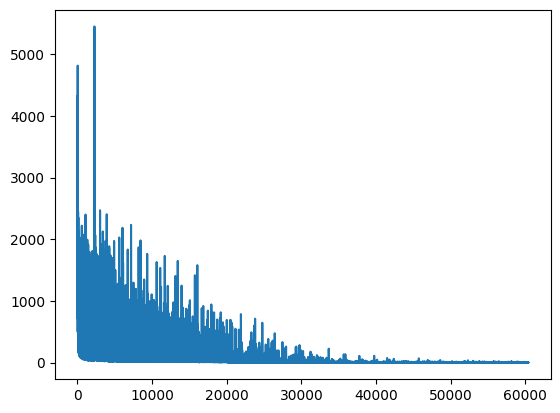

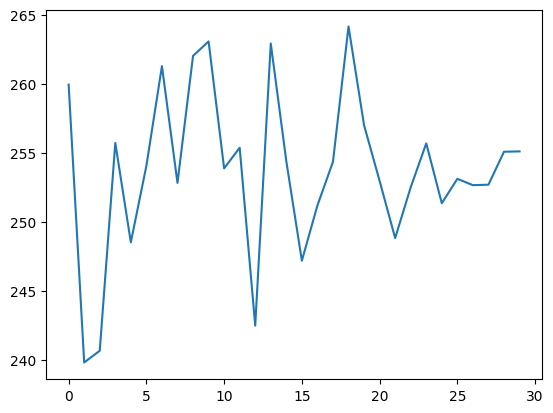

In [9]:
plt.plot(tr_loss)
plt.show()
plt.plot(dv_loss)
plt.show()

# Testing

In [10]:
del model
model = Decoder(idim, odim, ts).to(device)
ckpt = torch.load('best.pt', map_location='cpu')  # ckpt=check point, Load your best model
model.load_state_dict(ckpt)

<All keys matched successfully>

In [11]:
model.eval() # set model to evalutation mode
pred, real = np.zeros((0, odim)), np.zeros((0, odim))
for x, y in tt_load: # iterate through the dataloader
    x = x.to(device) # move data to device (cpu/cuda)
    with torch.no_grad(): # disable gradient calculation
        yh = model(x) # yh=y_hat. We usually use hat as a notation for estimation. 
        pred = np.concatenate((pred, yh.detach().cpu().numpy()))
    real = np.concatenate((real, y.detach().numpy()))

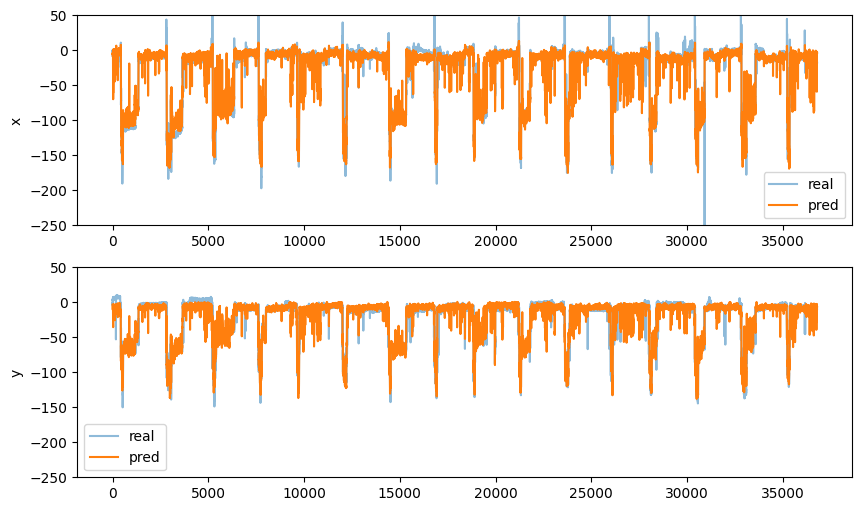

In [14]:
plt.figure(figsize = (10, 6))
plt.subplot(2,1,1)
plt.plot(real[:,0], alpha=0.5, label='real')
plt.plot(pred[:,0], label='pred')
plt.ylabel('x')
plt.ylim([-250, 50])
plt.legend()
plt.subplot(2,1,2)
plt.plot(real[:,1], alpha=0.5, label='real')
plt.plot(pred[:,1], label='pred')
plt.ylabel('y')
plt.ylim([-250, 50])
plt.legend()
plt.show()

In [13]:
r2 = r2_score(real, pred)
print(r2)

0.8990484639675977
